In [1]:
dataset_path = '/Users/theo/Downloads/ind_nifty50list.csv'

In [23]:
!pip3 install yfinance;
!pip3 install pandas_datareader;
!pip3 install statsmodels;

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

In [3]:
t = pd.read_csv(dataset_path)
it_t= t[t['Industry']=='IT']
fin_t= t[t['Industry']=='FINANCIAL SERVICES']

From the kaggle article I can see that the p-value for the cointegration test is less than 0.05 for the pair ADBE/MSFT, so I am just selecting those below.

In [4]:
tickers = ['ADBE', 'MSFT']
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018, 1, 1)
df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  2 of 2 completed


,ADBE,MSFT
Date,,
2017-12-22,175.000000,85.510002
2017-12-26,174.440002,85.400002
2017-12-27,175.360001,85.709999
2017-12-28,175.550003,85.720001
2017-12-29,175.240005,85.540001


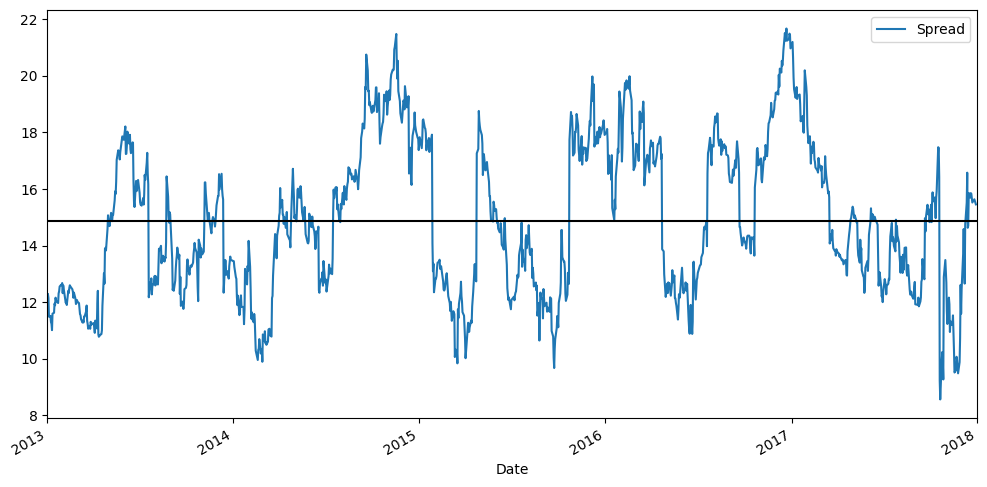

In [5]:
S1 = df['ADBE']
S2 = df['MSFT']
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread']);

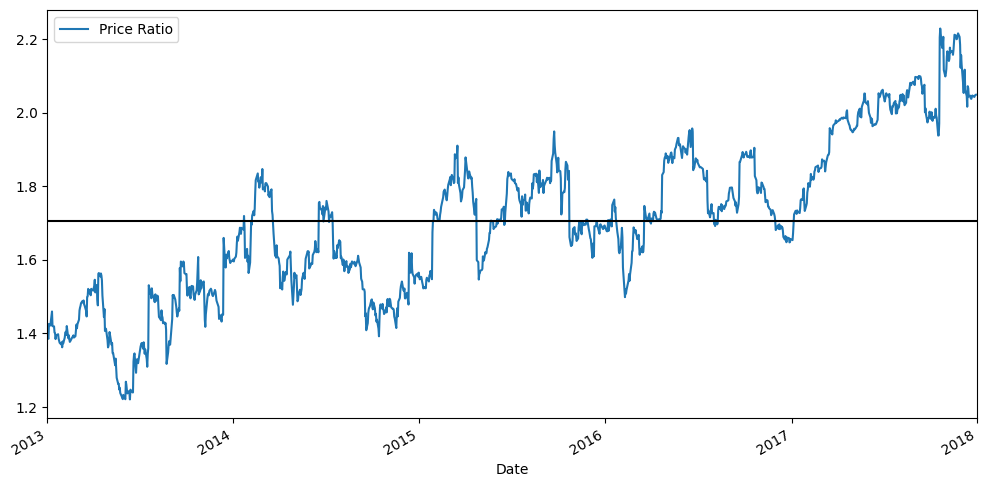

In [6]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio']);

Above is just confirmation that this pair is a mean-reverting one.

In [7]:
ratio

Date
2013-01-02    1.388125
2013-01-03    1.385321
2013-01-04    1.425954
2013-01-07    1.421506
2013-01-08    1.436535
                ...   
2017-12-22    2.046544
2017-12-26    2.042623
2017-12-27    2.045969
2017-12-28    2.047947
2017-12-29    2.048632
Length: 1259, dtype: float64

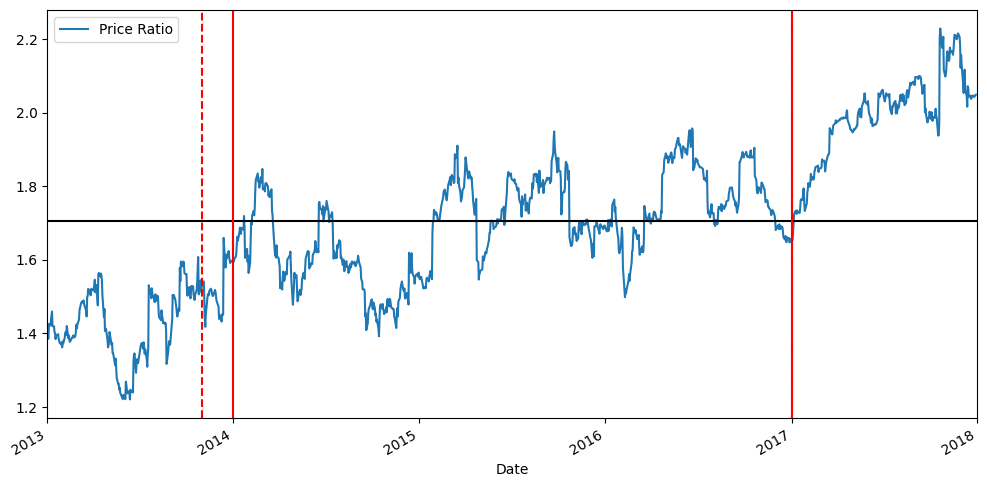

In [8]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2013-01-01', '2018-01-01')
plt.axvline(x='2014', color='red')
plt.axvline(x='2017', color='red')
plt.axvline(x='2013-11', color='red', linestyle='--')
plt.axvline(x='2017', color='red', linestyle='--')
plt.legend(['Price Ratio']);

Above is basically the period I selected during which I will test my pairs trading strategy in the file 'display_animation.ipynb', since it seems that only in that period we observe mean reversion. Start a month before 2014 to open a position.

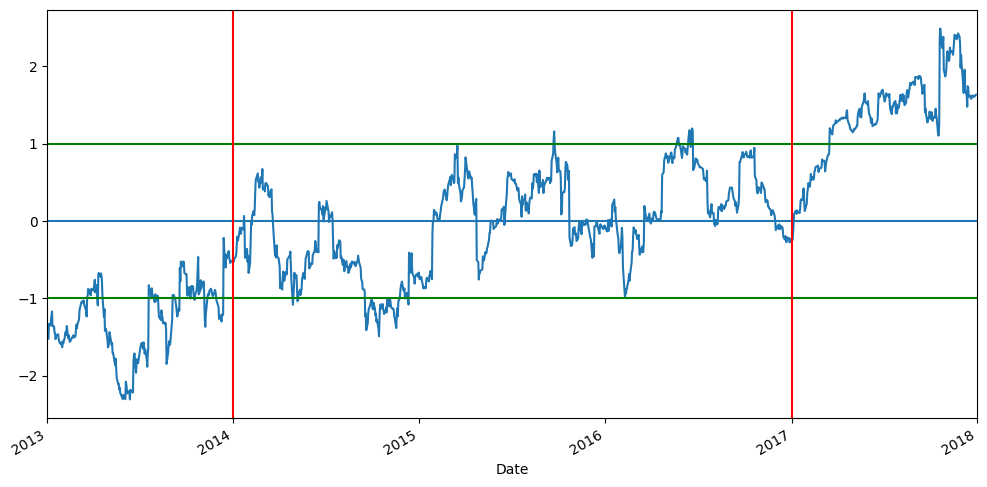

In [9]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='green')
plt.axhline(-1.0, color='green')
plt.axvline(x='2014', color='red')
plt.axvline(x='2017', color='red')
plt.xlim('2013-01-01', '2018-01-01')
plt.show()

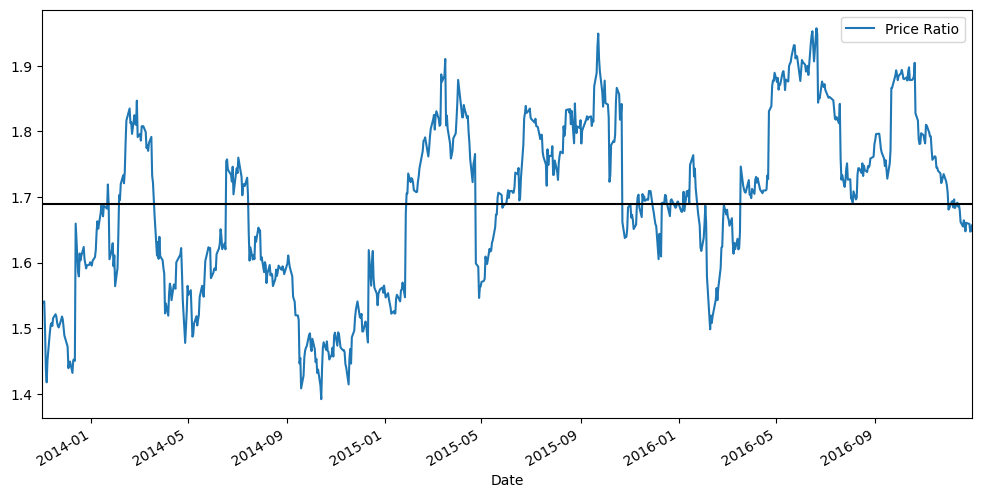

In [10]:
df = df[df.index >= '2013-11']
df = df[df.index <= '2017']

S1 = df['ADBE']
S2 = df['MSFT']
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim(df.index[0], df.index[-1])
plt.legend(['Price Ratio']);

In [77]:
position = 'closed'  # We are not in the market yet, so the trader has not submitted any order to the exchange yet.
balance = []  # Build P&L calculator, as part of the order management system.
x, y_fang, y_google = [], [], []  # Maintain present and history of stocks, component of the order management system.
longA, longB = [], []  # Mark the points in the animation specifying what we long on.
trades, closes = [], []  # Maintain a log of our trades, component of the order management system.


#plt.style.use('seaborn')
#fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 6))
def animation(i, s, ss, start):
    '''Implements a pairs trading strategy.
       Implements the conceptual things underlying an HFT system.'''    
    global position
    if i == 0:
        position = 'closed'
    global fang_price
    global fang_stock
    global google_stock
    global google_price

    x.append(i)  # Listener gathers market data from the exchange.
    y_fang.append(ss[i])  # Listener gathers market data from the exchange.
    y_google.append(s[i])  # Listener gathers market data from the exchange.

    if i < 10:
        balance.append(start)  # start with 1000 dollars
    if i >= 10:
        curr_mean = np.mean(np.array(y_fang)/np.array(y_google))  # Pricer calculates mean of ratio of stocks.
        curr_stdev = np.std(np.array(y_fang)/np.array(y_google))  # Pricer calculates std of ratio of stocks.


        ax1.clear()
        ax1.plot(x, y_fang)
        ax1.plot(x, y_google)
        ax1.title.set_text("FAANG ETF and Google")
        ax1.set_xticks([])

        ax2.clear()
        ratio = np.array(y_fang)/np.array(y_google)
        ax2.plot(x, ratio, 'r')
        ax2.plot((0,x[i]+1), (curr_mean, curr_mean), color='orange')
        ax2.title.set_text("Ratio graph")
        ax2.set_xticks([])


        if position=='closed':

            if ratio[i] - curr_mean > 0.15 * curr_mean:  # 15% positively away from the mean
                longB.append(i)  # Trade type is sent to logger. The trader longs on the google stock.
                trades.append(i)  # Trade occurs and is logged.
                position = 'short_long'  # Trader submits order to the exchange.

                # I am willing to invest half of current (positive) balance.
                # Pricer calculates the number of shares of etf that are shorted.
                fang_stock = -(balance[len(balance)-1]/2)/y_fang[i]
                fang_price = y_fang[i]

                # I am willing to invest half of current (positive) balance.
                # Pricer calculates the number of shares of google that are longed.
                google_stock = (balance[len(balance)-1]/2)/y_google[i]
                google_price = y_google[i]


                balance.append(balance[len(balance)-1])  # Balance is unchanged because no trade was closed.

            elif curr_mean - ratio[i] > 0.15 * curr_mean: # 15% negatively away from the mean
                longA.append(i)  # Trade type is sent to logger. The trader longs on the etf.
                trades.append(i)  # Trade occurs and is logged.
                position = 'long_short'  # Trader submits order to the exchange.

                # I am willing to invest half of current (positive) balance.
                # Pricer calculates the number of shares of etf that are longed.
                fang_stock = (balance[len(balance)-1]/2)/y_fang[len(y_fang)-1]
                fang_price = y_fang[i]

                # I am willing to invest half of current (positive) balance.
                # Pricer calculates the number of shares of google that are shorted.
                google_stock = -(balance[len(balance)-1]/2)/y_google[len(y_google)-1]
                google_price = y_google[i]

                ax2.plot(x[i], ratio[i], 'ko')

                balance.append(balance[len(balance)-1])  # Balance is unchanged because no trade was closed.
            else:
                balance.append(balance[len(balance)-1])  # Balance is unchanged because no trade was closed.

        elif position == 'short_long':
            if abs(ratio[i] - curr_mean) < 0.05 * curr_mean and ratio[i] - curr_mean > 0:
                position = 'closed'  # Trader submits order to the exchange and exits the trade.
                closes.append(i)  # Info about the trade is sent to the logger.

                # P&L calculator recalculates balance.
                balance.append(balance[len(balance)-1] + fang_stock*(y_fang[i] - fang_price) + google_stock*(y_google[i] - google_price))
            else:
                balance.append(balance[len(balance)-1])  # Trader does not take action, trade is still open.

        elif position == 'long_short':
            if abs(ratio[i] - curr_mean) < 0.05 * curr_mean and ratio[i] - curr_mean < 0:
                position = 'closed'  # Trader submits order to the exchange and exits the trade.
                closes.append(i)  # Info about the trade is sent to the logger.

                # P&L calculator recalculates balance.
                balance.append(balance[len(balance)-1] + fang_stock*(y_fang[i] - fang_price) + google_stock*(y_google[i] - google_price))
            else:
                balance.append(balance[len(balance)-1])  # Trader does not take action, trade is still open.

        for i in longB:
            ax1.plot(x[i], y_fang[i], 'mo')
            ax1.plot(x[i], y_google[i], 'co')
        for i in longA:
            ax1.plot(x[i], y_fang[i], 'co')
            ax1.plot(x[i], y_google[i], 'mo')
        for i in trades:
            ax2.plot(x[i], ratio[i], 'go')
        for i in closes:
            ax2.plot(x[i], ratio[i], 'ko')

        ax3.clear()
        ax3.plot(x, balance)
        ax3.title.set_text("Balance in $")
        ax3.set_xticks([])

In [78]:
adbe = df['ADBE']
msft = df['MSFT']
balance = []
from tqdm import tqdm
for i in tqdm(range(len(adbe))):
    animation(i, adbe, msft, start=1000)

100%|█████████████████████████████████████████| 797/797 [00:20<00:00, 39.45it/s]


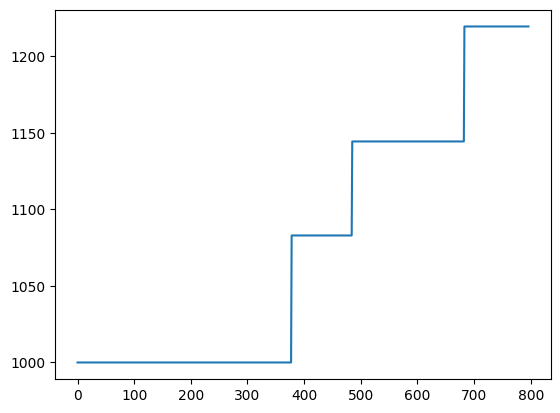

In [79]:
plt.plot(balance)

In [80]:
balance[-1]

1219.5137304956766

In [81]:
balance[0]

1000

As we can see, my strategy made 20% return, and only from 6 trades. The timeframe I looked at spanned 3 years, this does not mean much.

In [88]:
# Sharpe
daily_return = pd.Series(balance).pct_change()
daily_return.dropna(inplace=True)
n = len(daily_return)
mean = sum(daily_return) / n
deviations = sum([(x - mean)**2 for x in daily_return])
variance = deviations / (n - 1)
s = variance**(1/2)
daily_sharpe_ratio = mean / s
daily_sharpe_ratio

0.06069982592167179

In [66]:
adbe = df['ADBE']
msft = df['MSFT']
balance = []
from tqdm import tqdm
for i in tqdm(range(len(adbe))):
    animation(i, adbe, msft, start=100000)

100%|█████████████████████████████████████████| 797/797 [00:20<00:00, 39.33it/s]


In [67]:
balance[-1]

121951.37304956769

In [68]:
balance[0]

100000

The problem here lies in item 2 of readme, as the amount invested in each trade is half of the available amount, and this means a large order will be sent to the exchange, so the market impact will be significant - since I did not simulate this in my strategy, I would not be confident in this PnL.

The kaggle article makes small trades (volume 1 each), and I think it is better from the point of view of tackling item 2, since the price impact it will have on the market is significantly smaller than my strategy sometimes - basically during periods of `above the mean` you short the ratio by 1 every single day, whereas during periods of `below the mean` you long the ratio by 1 every single day. 

Another difference between my strategy and the one from the kaggle article is that once I send a buy order, I need to close it by a sell order before sending another buy order (same with sell order).


So the next step is to just evaluate the strategy from the Kaggle article in terms of Sharpe ratio, PnL, and Maximal Drawdown (which was not done in the Kaggle article!), since it has the same idea as mine, except a buy/sell order can be sent at any time regardless of the orders sent up to that point.

In [25]:
print(len(ratios) * 0.9)

717.3000000000001


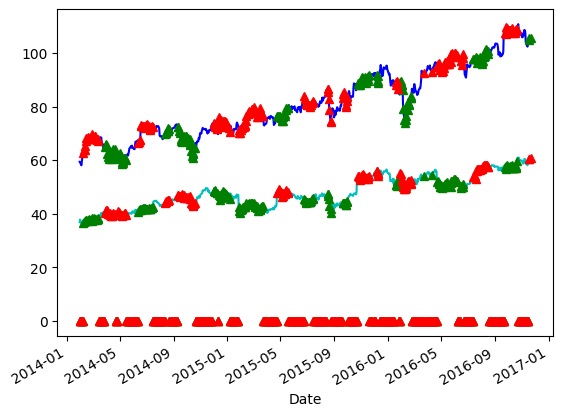

In [94]:
th = 770
balance = []
ratios = df['ADBE'] / df['MSFT']  
train = ratios[:th]
test = ratios[th:]
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
S1 = df['ADBE'].iloc[:th]
S2 = df['MSFT'].iloc[:th]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')

def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    balance = []
    money = 0
    balance.append(money)
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Recall ratios[i] = S1[i] / S2[i]
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]  # This equals 0! No price for entering long/short position.
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]  # This equals 0. No price for entering long/short position.
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2  # May be negative.
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
        balance.append(money)
            
    return money, balance

In [95]:
money, balance = trade(df['ADBE'].iloc[:], df['MSFT'].iloc[:], 60, 5)

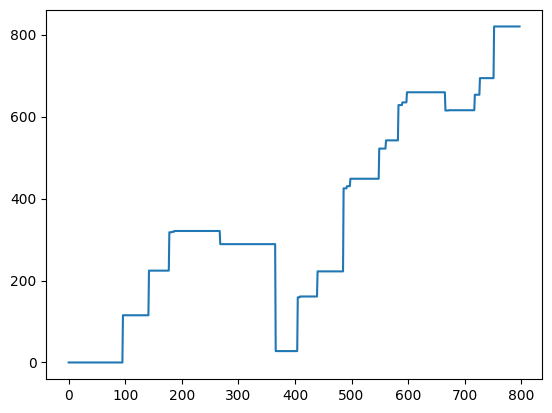

In [96]:
plt.plot(balance)

In [97]:
balance[-1]

819.823002274195

In [107]:
# Sharpe
daily_return = pd.Series(balance).pct_change()
daily_return.dropna(inplace=True)
daily_return = daily_return[1:]
n = len(daily_return)
mean = sum(daily_return) / n
deviations = sum([(x - mean)**2 for x in daily_return])
variance = deviations / (n - 1)
s = variance**(1/2)
daily_sharpe_ratio = mean / s
daily_sharpe_ratio

0.05339304532665072

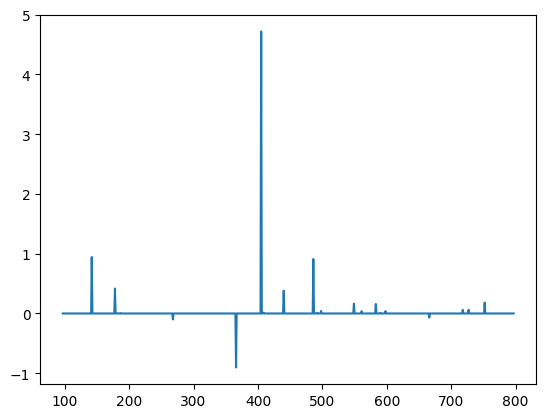

In [111]:
plt.plot(daily_return)

In [113]:
wealth_index = 1000*(1+daily_return).cumprod()
wealth_index.head()

97     1000.0
98     1000.0
99     1000.0
100    1000.0
101    1000.0
dtype: float64

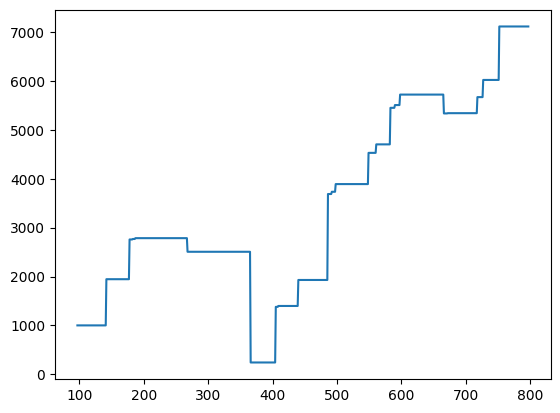

In [115]:
plt.plot(wealth_index)

In [116]:
previous_peaks = wealth_index.cummax()
previous_peaks.head()

97     1000.0
98     1000.0
99     1000.0
100    1000.0
101    1000.0
dtype: float64

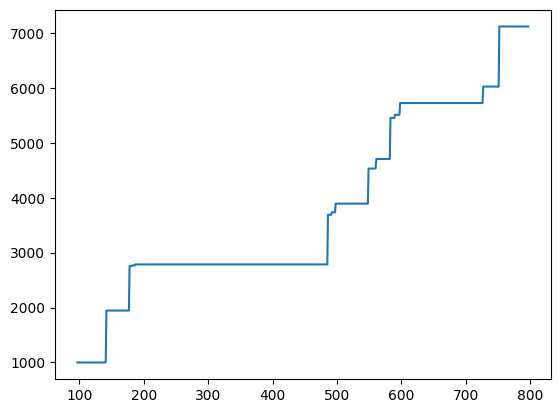

In [117]:
plt.plot(previous_peaks)

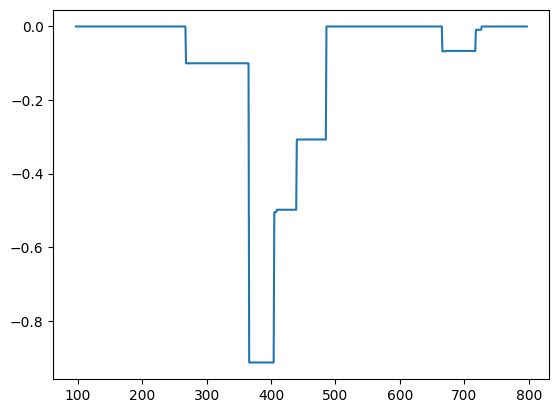

In [118]:
drawdown = (wealth_index - previous_peaks)/previous_peaks
plt.plot(drawdown)

In [119]:
drawdown.idxmin()

366

In [120]:
drawdown[366]

-0.9134128589101629

Overall, by doing everything in small chunks (iceberg-type) orders, so that we avoid revealing sensitive information to other market participants, this strategy (the one from the kaggle article) is more reliable short-term because of the significantly reduced market impact. 

It is worth mentioning that the money is not technically zeroed out when we short/long with the same dollar amount, due to the short selling margin existent in real life trading (see item 3, in the readme), which means that the real profit is subject to further subtractions because of this margin. This gives a plus to my strategy, since whenever I enter a trade, the dollar amount that the short position is worth is half of my total available balance, and not unlimited. I assume that I cannot borrow indefinitely, which is something that is not taken into consideration in the kaggle article. 

## Comparisons between the two strategies (numbers computed by me, not previously done in the kaggle article)

My strategy:
- horizon: long
- large-volume buy/sell orders since I enter positions less frequently (potentially having high market impact)
- limits value of the short position by always being just half of the total available investment amount
- Sharpe: 0.060
- maximal drawdown: 0%
- Dolar PnL at the end: ~ (6/5) * (2 * value of first short sell trade)

Strategy from Kaggle article:
- horizon: short
- small-volume buy/sell orders since it enters positions much more frequently, each time volume being 1 (market impact is significantly smaller due to iceberg-like orders)
- does not take into account short sell margin at all
- Sharpe: 0.053
- maximal drawdown: -91%  
- Dolar PnL at the end: 819

It seems that the two strategies are comparable, and I would choose mine if I were to trade mid-to-long term, and the one from the Kaggle article if I were to do a short term strategy.

Note that the daily Sharpe 0.06 corresponds to roughly a yearly Sharpe of 1 (multiplying 0.06 by $\sqrt{250}$), which is a reasonable Sharpe ratio, considering that in practice 0.3-0.4 is quite good a metric both for Sharpe but also for R^2 (too-good-to-be-true measures often give a sign of look-ahead bias, which can be hidden in situations like linearly-interpolating as a way to impute data in place of NaNs!)